# Bidirectional LSTM Sentiment Classifier

In this notebook, we use a bidirectional LSTM to classify IMDB movie reviews by their sentiment.

### Load Dependencies

In [1]:
import tensorflow
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, SpatialDropout1D, LSTM
from tensorflow.keras.layers import Bidirectional # new! 
from tensorflow.keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score 
import matplotlib.pyplot as plt

### Set Hyperparameters

In [2]:
# output directory name:
output_dir = 'model_output/biLSTM'

# training:
epochs = 20
batch_size = 128

# vector-space embedding: 
n_dim = 64 
n_unique_words = 10000 
max_review_length = 200 # doubled!
pad_type = trunc_type = 'pre'
drop_embed = 0.2 

# LSTM layer architecture:
n_lstm = 256 
drop_lstm = 0.2

### Load Data

In [3]:
(x_train, y_train), (x_valid, y_valid) = imdb.load_data(num_words=n_unique_words) # removed n_words_to_skip

17464789/17464789 [==============================] - 2s 0us/step


### Preprocess Data

In [4]:
x_train = pad_sequences(x_train, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)
x_valid = pad_sequences(x_valid, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)

### Design Neural Network Architecture

In [5]:
model = Sequential()

# First Hidden Layer:
model.add(Embedding(n_unique_words, n_dim, input_length=max_review_length)) 
model.add(SpatialDropout1D(drop_embed))

# Second Hidden Layer:
model.add(Bidirectional(LSTM(n_lstm, dropout=drop_lstm)))


# Output Layer:
model.add(Dense(1, activation='sigmoid'))

In [6]:
# LSTM layer parameters double due to both reading directions
model.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 64)           640000    
                                                                 
 spatial_dropout1d (SpatialD  (None, 200, 64)          0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 512)              657408    
 l)                                                              
                                                                 
 dense (Dense)               (None, 1)                 513       
                                                                 
Total params: 1,297,921
Trainable params: 1,297,921
Non-trainable params: 0
_________________________________________________________________


### Configure Model

In [7]:
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])

In [8]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

### Train !

In [9]:
# - with this toy dataset, the complex interplay of words over long sentence segments, won't be learned much
# - so our CNN picking up location-invariant segments of two to four words that predict review sentiment
# - these are simpler and so easier to learn from the data
# - CNN therefore outperforms on the IMDB data set
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_valid, y_valid), callbacks=[modelcheckpoint])

Epoch 1/20
196/196 [==============================] - 25s 79ms/step - loss: 0.5989 - accuracy: 0.6846 - val_loss: 0.4441 - val_accuracy: 0.8118
Epoch 2/20
196/196 [==============================] - 14s 72ms/step - loss: 0.3766 - accuracy: 0.8425 - val_loss: 0.5317 - val_accuracy: 0.7355
Epoch 3/20
196/196 [==============================] - 14s 74ms/step - loss: 0.3536 - accuracy: 0.8542 - val_loss: 0.3817 - val_accuracy: 0.8430
Epoch 4/20
196/196 [==============================] - 14s 73ms/step - loss: 0.2758 - accuracy: 0.8937 - val_loss: 0.3447 - val_accuracy: 0.8602
Epoch 5/20
196/196 [==============================] - 14s 72ms/step - loss: 0.2262 - accuracy: 0.9132 - val_loss: 0.3472 - val_accuracy: 0.8676
Epoch 6/20
196/196 [==============================] - 14s 74ms/step - loss: 0.1948 - accuracy: 0.9264 - val_loss: 0.3682 - val_accuracy: 0.8567
Epoch 7/20
196/196 [==============================] - 14s 72ms/step - loss: 0.1914 - accuracy: 0.9318 - val_loss: 0.3617 - val_accuracy:

### Evaluate 

In [10]:
model.load_weights(output_dir+"/weights.04.hdf5") 

In [12]:
y_hat = model.predict(x_valid)

782/782 [==============================] - 9s 10ms/step


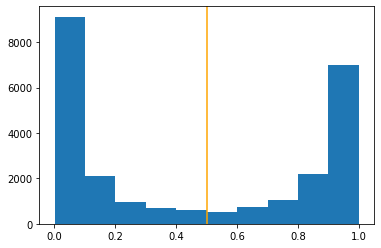

In [13]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [14]:
"{:0.2f}".format(roc_auc_score(y_valid, y_hat)*100.0)

'93.17'